**Contributor Names:**
1. Zitong
2. Kseniia

## Model:

\begin{array}{l l l l }
\max_{} &    \sum_{s \in S} \sum_{p \in P} v_{sp}x_{sp}              &   &\qquad \text{Maximize covered demand} \\
 s.t. & \ x_{sp} \leq \sum_{h \in H : (s,p) \in δ_{h}} y_{h} & \forall s \in S, \forall p\in P &\qquad  \text{Traveling from junction s to POI $p$ is only possible if one of the nearby hubs is opened}\\
& \sum_{h = N+1}^{M} y_{h} \leq U & &\qquad  \text{No more than $U$ location can be opened}\\
& \sum_{h = 1}^{N} y_{h} = N &  &\qquad \text{Existing hubs are fixed to be opened}\\
& x_{sp}, y_{h} \in \{0,1\} &\forall s\in S, \forall h\in H, \forall p\in P &\qquad  \text{Domain constraints}\\
\end{array}


## Sets:
$$
\begin{align*}
    H &: \text{set of hub indexes, where $h = 1,...,N$ refers to all existing hubs and indexes $h = N+1,...,M$ corresponds to all potential hub locations.}&&&&&\\
    P &: \text{Index set of POIs.}&&&&&\\
    S &: \text{Index set of all junction roads.}&&&&&\\
    δ_{h} &= \{(s,p)\in S * P | c_{sp} + Delta \geq c_{sh} + b_{hp} \; \text{and} \; b_{hp}\leq T \; \text{and} \; d_{hp} \geq D \; \text{and} \; d_{sp}- d_{sh} \geq τ \}&&&&&
\end{align*}
$$

## Parameters:
$$
\begin{array}{l l l l}
    v_{sp} &: \text{Demand from POI $p$, coming from junction $s$} &\\
    c_{sp} &: \text{Car travel time from junction $s$ to POI $p$ (min)} & \\
    c_{sh} &: \text{Car travel time from junction $s$ to hub $h$ (min)} & \\
    b_{hp} &: \text{Bike travel time from hub $h$ to POI $p$ (min)} & \\
    d_{sh} &: \text{Distance from junction $s$ to hub $h$ (kilometers)} & \\
    d_{sp} &: \text{Distance from junction $s$ to POI $p$ (kilometers)} & \\
    d_{hp} &: \text{Distance from hub $h$ to POI $p$ (kilometers)} & \\
    T &: \text{Longest accepted bike travel time from a hub to a POI (min)} & \\
    N &: \text{Number of existing hub locations} & \\
    U &: \text{Maximum number of new hubs planned to be opened} & \\
    D &: \text{Minimum distance between a hub and a POI (kilometers)} & \\
    Delta &: \text{Maximum allowed extra travel time by bike from car travel time (min)} & \\
    τ &: \text{Distance separating a hub location from a POI (kilometers)} &
\end{array}
$$

## Variables:
$$
\begin{align*}
    & x_{sp} = \begin{cases} 1 & \text{if an opened hub $h \in H$ such that $c_{sp} + Delta \geq c_{sh} + b_{hp} \; \text{and} \; b_{hp}\leq T \; \text{and} \; d_{hp} \geq D \; \text{and} \; d_{sp}- d_{sh} \geq τ$ } \\0 & \text{if not}\end{cases} \\
    & y_{h} = \begin{cases} 1 & \text{if hub $h$ is opened} \\0 & \text{else}\end{cases}
\end{align*}
$$

In [ ]:
# check environment and import packages
import sys
at_colab = 'google.colab' in sys.modules
if at_colab:
    %pip install xlsxwriter
    %pip install pyomo
    !apt-get install -y -qq coinor-cbc

import pandas as pd
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

!pip install folium openpyxl
import folium

from PIL import Image
import io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcg

In [ ]:
# load data
data = pd.ExcelFile("mobian_data.xlsx")

# data preparation
data_mapping = {
    'v': 'v',
    'd_jh': 'd_jh',
    'd_hp': 'd_hp',
    'd_jp': 'd_jp',
    'c_jh': 'c_jh',
    'c_jp': 'c_jp',
    'b_hp': 'b_hp',
    'junctions': 'junctions',
    'hubs': 'hubs',
    'pois': 'pois',
    'single_parameters': 'single_parameters',
    'ams_network_car': 'ams_network_car',
    'ams_network_bike': 'ams_network_bike',
    'explanation': 'explanation of different sheets'
}

# substract sheet from the excel file
df = {}

for data_name, sheet_name in data_mapping.items():
    df[data_name] = pd.read_excel("mobian_data.xlsx", sheet_name=sheet_name, engine='openpyxl')

In [ ]:
# prepare single parameters
U = df['single_parameters'].loc[:,'U'].iloc[0] # 7
N = df['single_parameters'].loc[:,'N'].iloc[0] # 0

T = df['single_parameters'].loc[:,'T'].iloc[0] # 45
D = df['single_parameters'].loc[:,'D'].iloc[0] # 0.05
Delta = df['single_parameters'].loc[:,'Delta'].iloc[0] # 15
tau = df['single_parameters'].loc[:,'tau'].iloc[0] # 0.02

# set up model
m = pyo.ConcreteModel()

# sets
m.H = pyo.Set(initialize = df['hubs'].index) # 0 to 156
m.P = pyo.Set(initialize = df['pois'].index) # 0 to 76
m.S = pyo.Set(initialize = df['junctions'].index) # 0 to 4

# variables
m.x = pyo.Var(m.S, m.P, within = pyo.Binary)
m.y = pyo.Var(m.H, within = pyo.Binary)

# Parameters
m.v_sp = pyo.Param(m.S, m.P, initialize=lambda m, s, p: df['v'].iloc[s, p])
m.c_sh = pyo.Param(m.S, m.H, initialize=lambda m, s, h: df['c_jh'].iloc[s, h])
m.c_sp = pyo.Param(m.S, m.P, initialize=lambda m, s, p: df['c_jp'].iloc[s, p])
m.b_hp = pyo.Param(m.H, m.P, initialize=lambda m, h, p: df['b_hp'].iloc[h, p])
m.d_sp = pyo.Param(m.S, m.P, initialize=lambda m, s, p: df['d_jp'].iloc[s, p])
m.d_hp = pyo.Param(m.H, m.P, initialize=lambda m, h, p: df['d_hp'].iloc[h, p])
m.d_sh = pyo.Param(m.S, m.H, initialize=lambda m, s, h: df['d_jh'].iloc[s, h])

m.T = T
m.D = D
m.Delta = Delta
m.tau = tau

# calculation of delta parameter
def delta_h(m, h):
  result = set()
  for s in m.S:
    for p in m.P:
      if(
          m.c_sp[s, p] + m.Delta >= m.c_sh[s, h] + m.b_hp[h, p]
          and m.b_hp[h, p] <= m.T
          and m.d_hp[h, p] >= m.D
          and m.d_sp[s, p] - m.d_sh[s, h] >= m.tau
      ):
        result.add((s, p))
  return result

# Constraints
m.con1 = pyo.Constraint(m.S, m.P, rule=lambda m, s, p: sum(m.y[h] for h in m.H if (s, p) in delta_h(m, h)) >= m.x[s, p])
m.con2 = pyo.Constraint(rule=lambda m: sum(m.y[h] for h in range(N+1,len(df['hubs']))) <= U)
m.con3 = pyo.Constraint(rule=lambda m: sum(m.y[h] for h in range(0, N+1)) == N)

# objective function
@m.Objective(sense = pyo.maximize)
def obj(m):
    return sum(m.v_sp[s, p] * m.x[s, p] for s in m.S for p in m.P)

# solve the model
solver = pyo.SolverFactory('cbc')
solver.solve(m)

{'Problem': [{'Name': 'unknown', 'Lower bound': 9587.1546199, 'Upper bound': 9587.1546199, 'Number of objectives': 1, 'Number of constraints': 374, 'Number of variables': 529, 'Number of binary variables': 542, 'Number of integer variables': 542, 'Number of nonzeros': 373, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.1, 'Wallclock time': 0.12, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.1613156795501709}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
# maximized demand
print("Objective value:", pyo.value(m.obj))

# hub location
print("New Hub Locations:")
for h in range(N+1, len(df['hubs'])):
    if pyo.value(m.y[h]) == 1:
        print(f'Hub {h} is opened.')

Objective value: 9587.154619899988
New Hub Locations:
Hub 6 is opened.
Hub 13 is opened.
Hub 25 is opened.
Hub 48 is opened.
Hub 73 is opened.
Hub 95 is opened.
Hub 107 is opened.


## Visualization ##

In [ ]:
# latitude and longitude for Amsterdam map
ams_lat, ams_lon = 52.3676, 4.9041

# list of newly opened hubs
new_hubs_indices = [h for h in range(N+1, len(df['hubs'])) if pyo.value(m.y[h]) == 1]

# Create a map
m_map = folium.Map(location=[ams_lat, ams_lon], zoom_start=11.5,width="%100",height="%100")

# Plot the newly opened hubs as orange markers
for h in new_hubs_indices:
  row = df['hubs'].iloc[h]
  hub_index = f"Hub Index: {h}"  # Get the hub index

  # create a marker for the hub
  folium.Marker(
      [row['Latitude'], row['Longitude']],
      tooltip=folium.Tooltip(text=f"{row['Name']}<br>{hub_index}", permanent=True),  # name and index in the tooltip, permanently show the tooltip
      icon=folium.Icon(color='orange')
  ).add_to(m_map)

# Plot junctions and POIs
for s in m.S:
  for p in m.P:
    if pyo.value(m.x[s, p]) == 1:
      poi_row = df['pois'].iloc[p]
      junction_row = df['junctions'].iloc[s]

      # Create a marker for junctions
      junction_index = f"Junction Index: {s}"

      # Create a blue marker for junctions
      folium.Marker(
          [junction_row['Latitude'], junction_row['Longitude']],
          tooltip=f"{junction_row['Roads']}<br>{junction_index}",  # roads and index in the tooltip
          icon=folium.Icon(color='blue')
      ).add_to(m_map)

      # create a marker for POIs
      poi_index = f"POI Index: {p}"

      # create a red circle marker for POIs
      folium.CircleMarker(
          [poi_row['Latitude'], poi_row['Longitude']],
          width="%100",
          height="%100",
          radius=5,
          fill = True,
          color='red',
          tooltip=f"{poi_row['Adress']}<br>{poi_index}"  # address and index in the tooltip
      ).add_to(m_map)

In [ ]:
#addidng and legend to the map
types_colors = dict(
    J = '#39A9DD',
    H = 'orange',
    POI= 'red'
)

node_type = dict(
    J= 'Junction',
    H= 'Hub',
    POI= 'Point of interest (POI)',
)

legend_html = """
<div style="position: fixed;
top: 20px;
right: 30px;
z-index: 9999;
font-size: 15px;
background-color: white;
padding: 10px;">
<p><strong>Legend</strong></p>
"""

for category, color in types_colors.items():
    legend_html += f'<i class="fa fa-circle fa-1x" style="color:{color}"></i> {node_type[category]}<br>'
legend_html += "</div>"

m_map.get_root().html.add_child(folium.Element(legend_html))
m_map

In [ ]:
m_map.save("map.html")

## Sensitivity Analysis / What-if Analysis ##
##### 1. Is it worthy to open the last hub?
##### 2. How to prioritize the hub that we plan to open

In [ ]:
# initialize data
U_max = df['single_parameters'].loc[:, 'U'].iloc[0] + 10
N = df['single_parameters'].loc[:,'N'].iloc[0]
T = df['single_parameters'].loc[:,'T'].iloc[0]
D = df['single_parameters'].loc[:,'D'].iloc[0]
Delta = df['single_parameters'].loc[:,'Delta'].iloc[0]
tau = df['single_parameters'].loc[:,'tau'].iloc[0]

In [ ]:
# Create lists to store results
obj_vals = []
hub_cnt = []
newly_opened_hubs_dict = {}

# Loop through all U values
for U_value in range(U_max, 0, -1):
    U = U_value

    m = pyo.ConcreteModel()

    m.H = pyo.Set(initialize = df['hubs'].index) # 0 to 156
    m.P = pyo.Set(initialize = df['pois'].index) # 0 to 76
    m.S = pyo.Set(initialize = df['junctions'].index) # 0 to 4

    m.x = pyo.Var(m.S, m.P, within = pyo.Binary)
    m.y = pyo.Var(m.H, within = pyo.Binary)

    m.v_sp = pyo.Param(m.S, m.P, initialize=lambda m, s, p: df['v'].iloc[s, p])
    m.c_sh = pyo.Param(m.S, m.H, initialize=lambda m, s, h: df['c_jh'].iloc[s, h])
    m.c_sp = pyo.Param(m.S, m.P, initialize=lambda m, s, p: df['c_jp'].iloc[s, p])
    m.b_hp = pyo.Param(m.H, m.P, initialize=lambda m, h, p: df['b_hp'].iloc[h, p])
    m.d_sp = pyo.Param(m.S, m.P, initialize=lambda m, s, p: df['d_jp'].iloc[s, p])
    m.d_hp = pyo.Param(m.H, m.P, initialize=lambda m, h, p: df['d_hp'].iloc[h, p])
    m.d_sh = pyo.Param(m.S, m.H, initialize=lambda m, s, h: df['d_jh'].iloc[s, h])

    m.T = T
    m.D = D
    m.Delta = Delta
    m.tau = tau

    def delta_h(m, h):
      result = set()
      for s in m.S:
        for p in m.P:
          if(
              m.c_sp[s, p] + m.Delta >= m.c_sh[s, h] + m.b_hp[h, p]
              and m.b_hp[h, p] <= m.T
              and m.d_hp[h, p] >= m.D
              and m.d_sp[s, p] - m.d_sh[s, h] >= m.tau
          ):
            result.add((s, p))
      return result

    m.con1 = pyo.Constraint(m.S, m.P, rule=lambda m, s, p: sum(m.y[h] for h in m.H if (s, p) in delta_h(m, h)) >= m.x[s, p])
    m.con2 = pyo.Constraint(rule=lambda m: sum(m.y[h] for h in range(N+1,len(df['hubs']))) <= U)
    m.con3 = pyo.Constraint(rule=lambda m: sum(m.y[h] for h in range(0, N+1)) == N)

    @m.Objective(sense = pyo.maximize)
    def obj(m):
        return sum(m.v_sp[s, p] * m.x[s, p] for s in m.S for p in m.P)

    # Solve the model
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)

    # Extract and store the objective value
    obj_vals.append(pyo.value(m.obj))
    hub_cnt.append(U)
    newly_opened_hubs = [h for h in m.H if pyo.value(m.y[h]) == 1]
    newly_opened_hubs_dict[U] = newly_opened_hubs

For U = 17, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 16, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 15, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 14, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 13, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 12, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 11, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 10, opened hubs are: [4, 6, 13, 19, 25, 47, 48, 61, 73, 95]
For U = 9, opened hubs are: [4, 6, 13, 19, 25, 48, 61, 73, 95]
For U = 8, opened hubs are: [4, 6, 13, 25, 48, 61, 73, 95]
For U = 7, opened hubs are: [6, 13, 25, 48, 73, 95, 107]
For U = 6, opened hubs are: [6, 13, 48, 73, 107, 156]
For U = 5, opened hubs are: [6, 13, 48, 73, 156]
For U = 4, opened hubs are: [6, 13, 48, 156]
For U = 3, opened hubs are: [6, 13, 145]
For U = 2, opened hubs are: [27, 145]
For U = 1, opened hubs are: [139]


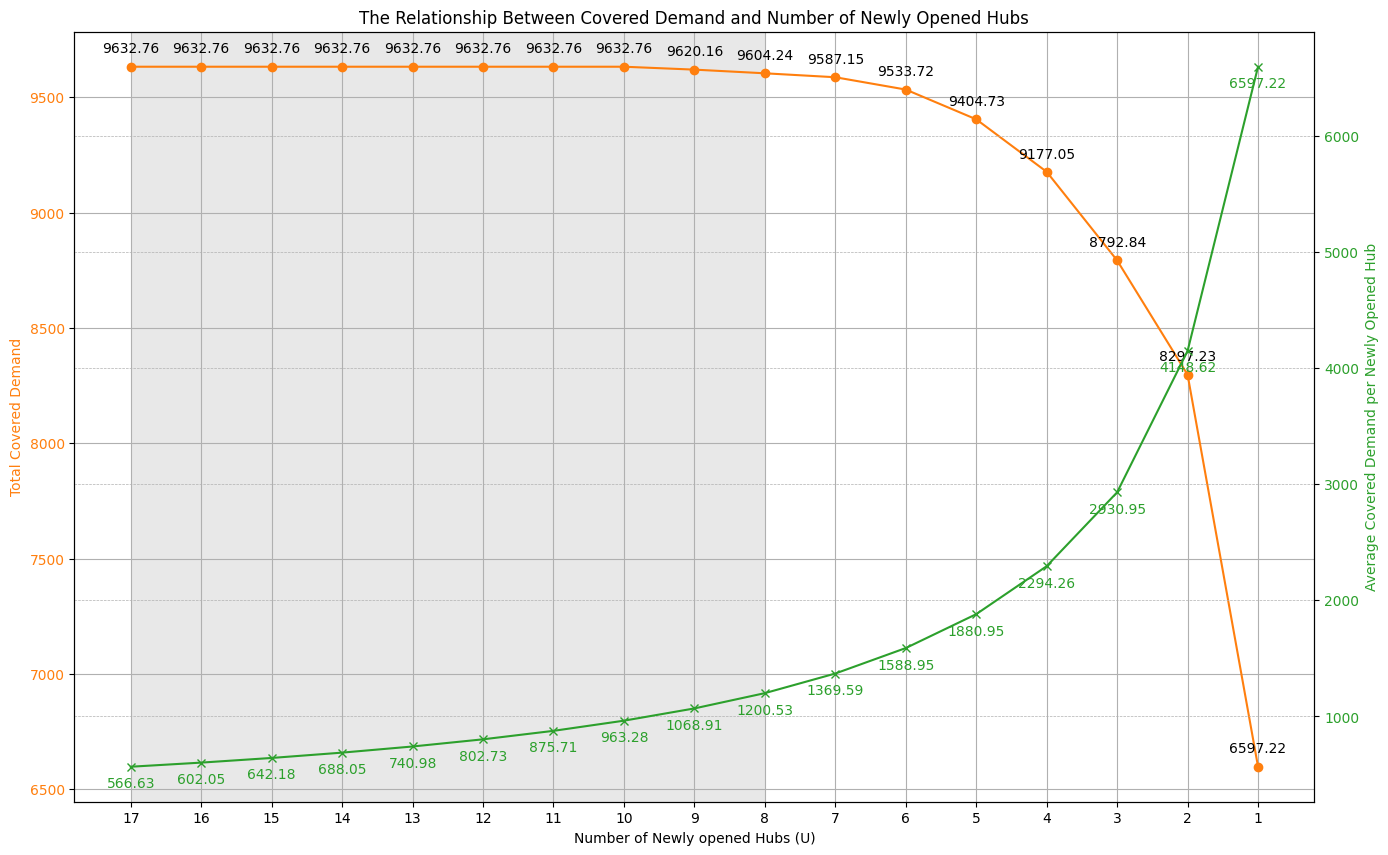

In [ ]:
# display the number of opened hubs for different U to identify the priority
for U_value, hubs in newly_opened_hubs_dict.items():
    print(f"For U = {U_value}, opened hubs are: {hubs}")

U_num = list(newly_opened_hubs_dict.keys())
hub_num = [len(newly_opened_hubs_dict[U]) for U in U_num]

# calculate average covered demand per hub with different U applied
avg_covered_demand = [round(ttl_demand / num, 2) for ttl_demand, num in zip(obj_vals, hub_cnt)]

# plotting
fig, ax1 = plt.subplots(figsize=(16, 10))

# highlight the region from 8 to 17
ax1.axvspan(8, 17, facecolor='lightgrey', alpha=0.5)

# total covered demand and number of hubs
color = 'tab:orange'
ax1.set_xlabel('Number of Newly opened Hubs (U)')
ax1.set_ylabel('Total Covered Demand', color=color)
ax1.plot(hub_cnt, obj_vals, marker='o', color=color, label='Total Covered Demand')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(None)

# annotate each dot with two decimal places
for i, txt in enumerate(obj_vals):
    ax1.annotate(f"{txt:.2f}", (hub_cnt[i], obj_vals[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# set xticks to show each U from 1 to 17
ax1.set_xticks(list(range(1, 18)))
ax1.invert_xaxis()

# average covered demand per hub and number of hubs
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Average Covered Demand per Newly Opened Hub', color=color)
ax2.plot(hub_cnt, avg_covered_demand, marker='x', color=color, label='Average Covered Demand per Hub')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# annotate each dot with two decimal places
for i, txt in enumerate(avg_covered_demand):
    ax2.annotate(f"{txt:.2f}", (hub_cnt[i], avg_covered_demand[i]), textcoords="offset points", xytext=(0, -15), ha='center', color=color)

plt.title('The Relationship Between Covered Demand and Number of Newly Opened Hubs')
plt.show()
